In this challenge, the non-profit organisation CDP, which is short for 'Carbon Disclosure Project', has provided us environmental information by disclosing corporations and cities. Every year cities are given one questionnaire and corporations are given two questionnaires (one on climate change and one on water security). These are detailed questionnaires. Therefore, the dataset containing disclosed information since 2018 is extensive. To be able to work with this kind of dataset, this notebooks aims at providing an overview of the data and a first look into it.
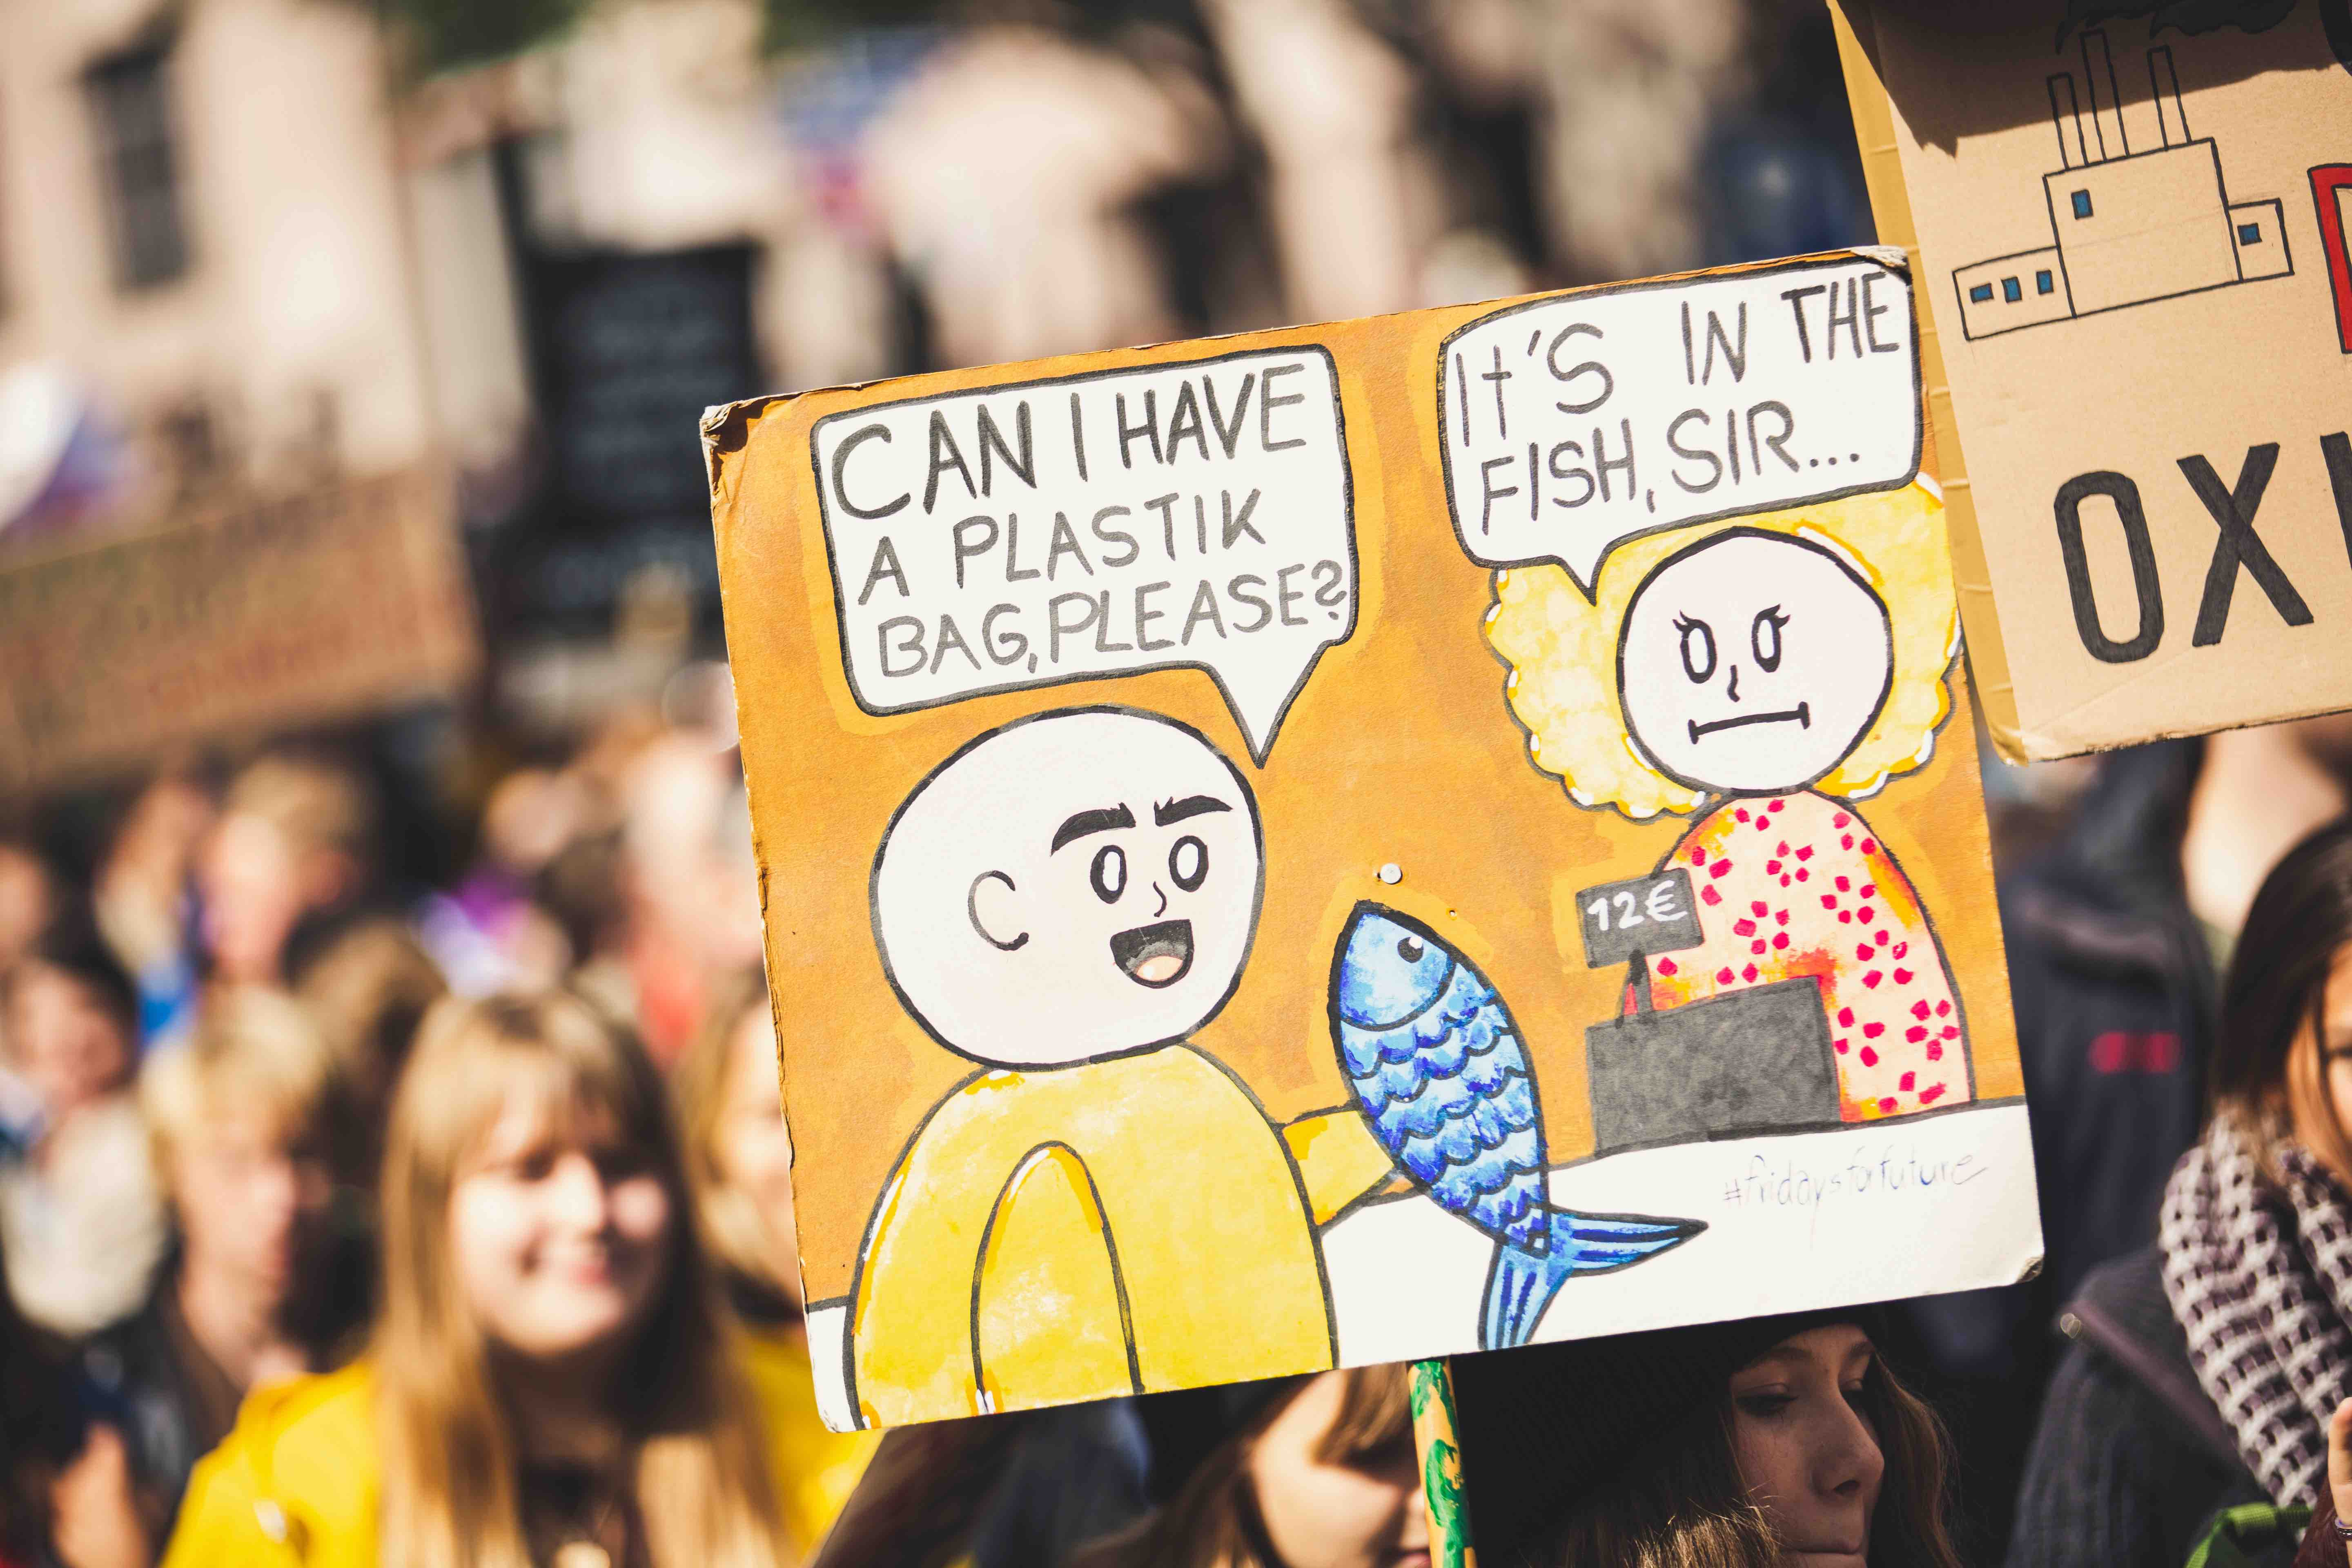
Photo by [Markus Spiske](https://unsplash.com/@markusspiske?utm_source=unsplash&amp;utm_medium=referral&amp;utm_content=creditCopyText) on Unsplash.



In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#pd.set_option('display.max_colwidth', -1)

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib_venn import venn2, venn2_circles

from matplotlib.patches import Rectangle, Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D

import warnings
warnings.filterwarnings('ignore')

import re
import string

import spacy # Leading library for NLP
nlp = spacy.load('en')
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import SnowballStemmer

from sklearn import preprocessing

# import cities response df
PATH = "../input/cdp-unlocking-climate-solutions/"


In [ ]:
# Load data and unify column_names, columns, and values for further processing
corporations_disclosing_df = pd.DataFrame()
corporations_df = pd.DataFrame()

cities_disclosing_df = pd.DataFrame()
cities_df = pd.DataFrame()

for year in [2018, 2019, 2020]:
    # Load corporations disclosing
    climate_disclosing = pd.read_csv(f"{PATH}Corporations/Corporations Disclosing/Climate Change/{year}_Corporates_Disclosing_to_CDP_Climate_Change.csv")
    corporations_disclosing_df = corporations_disclosing_df.append(climate_disclosing)
    
    water_disclosing = pd.read_csv(f"{PATH}Corporations/Corporations Disclosing/Water Security/{year}_Corporates_Disclosing_to_CDP_Water_Security.csv")
    corporations_disclosing_df = corporations_disclosing_df.append(water_disclosing)
    
    # Load corporations' responses
    climate = pd.read_csv(f"{PATH}Corporations/Corporations Responses/Climate Change/{year}_Full_Climate_Change_Dataset.csv")
    climate['questionnaire'] = 'Corporations Climate Change'
    climate['section'] = 'tbd'
    climate['question_number_major'] = climate['question_number'].apply(lambda x: float(x.split('.')[0][1:]))
    climate['question_number_minor'] = climate['question_number'].apply(lambda x: x.split('.')[1])
    
    corporations_df = corporations_df.append(climate)
    
    water = pd.read_csv(f"{PATH}Corporations/Corporations Responses/Water Security/{year}_Full_Water_Security_Dataset.csv")
    water['questionnaire'] = 'Corporations Water'
    water['section'] = 'tbd'
    water['question_number_major'] = water['question_number'].apply(lambda x: x.split('.')[0])
    water['question_number_major'] = water['question_number_major'].apply(lambda x: int(x.split('-')[1][-1]) if (len(x.split('-')) > 1) else float(x[1:]) )
    water['question_number_minor'] = water['question_number'].apply(lambda x: x.split('.')[1])
    
    corporations_df = corporations_df.append(water)
    
    # Load cities disclosing
    cities_disclosing = pd.read_csv(f"{PATH}Cities//Cities Disclosing/{year}_Cities_Disclosing_to_CDP.csv")
    cities_disclosing_df = cities_disclosing_df.append(cities_disclosing)

    # Load cities' responses
    cities = pd.read_csv(f"{PATH}Cities/Cities Responses/{year}_Full_Cities_Dataset.csv")
    cities['question_number_major'] = cities['Question Number'].apply(lambda x: x.split('.')[0])
    cities['question_number_minor'] = cities['Question Number'].apply(lambda x: x.split('.')[1] if (len(x.split('.')) > 1) else '')
    cities_df = cities_df.append(cities)


def unify_column_names_city(columns):
    """
    Unifies column naming to lower letters and underscores
    """
    new_cols = []
    for c in columns:
        if c == 'Year Reported to CDP':
            new_cols.append('survey_year')
        elif c == 'Response Answer':
            new_cols.append('response_value')
        elif c == 'Column Name':
            new_cols.append('subquestion_name')
        else:
            new_cols.append(re.sub(' ','_', c.lower()))

    return new_cols

def unify_column_names_corp(columns):
    new_cols = []
    """
    Unifies column naming to match column names in city questionnaire
    """
    for c in columns:
        if c == 'question_unique_reference':
            new_cols.append('question_name')
        elif c == 'module_name':
            new_cols.append('parent_section')
        elif c == 'data_point_name':
            new_cols.append('subquestion_name')
        else:
            new_cols.append(c)

    return new_cols

# Unify column names
cities_df.columns = unify_column_names_city(cities_df.columns)
cities_disclosing_df.columns = unify_column_names_city(cities_disclosing_df.columns)

corporations_df.columns = unify_column_names_corp(corporations_df.columns)
#cities_disclosing_df.columns = unify_column_names_corp(cities_disclosing_df.columns)
common_columns = [c for c in corporations_df.columns if c in cities_df.columns]
#print(f"Common columns in responses: {common_columns}")

# Unify column 'module_name' and 'questionnaire'
corporations_df['parent_section'] = corporations_df['parent_section'].apply(lambda x: x.split('. ')[1])
cities_df.questionnaire = 'Cities'

# Overview of Questionnaires
The questionnaires are very long and contain a lot of different questions and sections that change over the years. In this section, we will get an overview of the sections and their questions.

## Sections
Changes in the parent sections over the years:
* Corporations:
    * Climate Change: Parent section 'Governance' was added in 2020
    * Water: Parent section 'Linkages and trade-offs' was removed in 2020
* Cities:
    * The sections were revised after 2018 but have not changed since. For the following the 2018 questionnaire is modified to somewhat match the 2019 and 2020 questionnaire.

In [ ]:
corporation_sections_by_year = corporations_df.groupby(['questionnaire', 'question_number_major', 'parent_section', 'survey_year']).survey_year.nunique().to_frame()
corporation_sections_by_year.columns = ['count']
corporation_sections_by_year = corporation_sections_by_year.reset_index(drop=False)
corporation_sections_by_year = corporation_sections_by_year.pivot(index=['questionnaire', 'question_number_major', 'parent_section'], columns='survey_year')['count'].fillna(0)

for c in corporation_sections_by_year.columns:
    corporation_sections_by_year[c] = corporation_sections_by_year[c].astype(int)

def color_negative_red(val):
    color = 'Orangered' if val > 0 else 'gray'
    return 'background-color: %s' % color

corporation_sections_by_year.style.applymap(color_negative_red)

In [ ]:
dict_parent_section = {'City Wide Emissions' : 'City-wide Emissions',
                      'Climate Hazards' : 'Climate Hazards and Vulnerability',
                      'Climate Hazards & Vulnerability' : 'Climate Hazards and Vulnerability',
                      'Emissions Reduction: City-wide' : 'Emissions Reduction',
                      'Emissions Reduction: Local Government' : 'Emissions Reduction',
                      'Local Government Operations GHG Emissions Data' : 'Local Government Emissions',
                      'Water' : 'Water Security',
                       'Strategy' : 'Emissions Reduction',
                      }

dict_section = {'GHG Emissions Data' : 'City-wide GHG Emissions Data',
                'Risk and Vulnerability Assessment' : 'Climate Risk and Vulnerability Assessment',
                'Emissions Reduction Actions : City-wide' : 'Mitigation Actions',
                'Emissions Reduction Actions: Local Government' : 'Mitigation Actions',
                'Emissions Reduction: City-wide' : 'Mitigation Actions',
                'Emissions Reduction: Local Government' : 'Mitigation Actions',
                'Emissions Verification' : 'Local Government Emissions Verification',
                'Boundary & Scope' : 'Local Government Operations GHG Emissions Data',
                'Scope 3 Emissions' : 'Local Government Operations GHG Emissions Data',
                'Data Management' : 'Governance'
               }

cities_df['parent_section'] = np.where((cities_df['parent_section'].isna()), cities_df['section'], cities_df['parent_section']) 

cities_df['parent_section'] = cities_df['parent_section'].replace(dict_parent_section)
cities_df['section'] = cities_df['section'].replace(dict_section)

cities_df['parent_section'] = np.where(((cities_df['parent_section']=="Hazards and Adaptation") & (cities_df['section']=="Climate Hazards") & (cities_df['survey_year']==2018)), 'Climate Hazards and Vulnerability', cities_df['parent_section']) 
cities_df['section'] = np.where(((cities_df['parent_section']=="Hazards and Adaptation") & (cities_df['section']=="Climate Hazards") & (cities_df['survey_year']==2018)), 'Climate Risk and Vulnerability Assessment', cities_df['section']) 

cities_df['parent_section'] = np.where(((cities_df['parent_section']=="Hazards and Adaptation") & (cities_df['section']=="Adaptation") & (cities_df['survey_year']==2018)), 'Adaptation', cities_df['parent_section']) 
cities_df['section'] = np.where(((cities_df['parent_section']=="Hazards and Adaptation") & (cities_df['section']=="Adaptation") & (cities_df['survey_year']==2018)), 'Adaptation Planning', cities_df['section']) 

cities_df['parent_section'] = np.where(((cities_df['parent_section']=="Energy Data") & (cities_df['section']=="Scope 1 Emissions Breakdown") & (cities_df['survey_year']==2018)), 'Local Government Emissions', cities_df['parent_section']) 
cities_df['section'] = np.where(((cities_df['parent_section']=="Energy Data") & (cities_df['section']=="Scope 1 Emissions Breakdown") & (cities_df['survey_year']==2018)), 'Local Government Operations GHG Emissions Data', cities_df['section']) 

cities_df['parent_section'] = np.where(((cities_df['parent_section']=="GHG Emissions Data") & (cities_df['section']=="IPCC Emissions Breakdown") & (cities_df['survey_year']==2018)), 'City-wide Emissions', cities_df['parent_section']) 
cities_df['section'] = np.where(((cities_df['parent_section']=="GHG Emissions Data") & (cities_df['section']=="IPCC Emissions Breakdown") & (cities_df['survey_year']==2018)), 'City-wide GHG Emissions Data', cities_df['section']) 

cities_df['parent_section'] = np.where(((cities_df['parent_section']=="City-wide Emissions") & (cities_df['section']=="IPCC Emissions Breakdown") & (cities_df['survey_year']==2018)), 'City-wide Emissions', cities_df['parent_section']) 
cities_df['section'] = np.where(((cities_df['parent_section']=="City-wide Emissions") & (cities_df['section']=="IPCC Emissions Breakdown") & (cities_df['survey_year']==2018)), 'City-wide GHG Emissions Data', cities_df['section']) 

#cities_df['Parent Section'] = np.where(((cities_df['Parent Section']=="City-wide Emissions") & (cities_df['Section']=="City-wide GHG Emissions Data") & (cities_df['Questionnaire']=="CDP Cities 2018")), 'GHG Emissions Data', cities_df['Parent Section']) 
#cities_df['Section'] = np.where(((cities_df['Parent Section']=="City-wide Emissions") & (cities_df['Section']=="City-wide GHG Emissions Data") & (cities_df['Questionnaire']=="CDP Cities 2018")), 'US Community Protocol Emissions Breakdown', cities_df['Section']) 

cities_df['question_number_major'] = np.where(((cities_df['parent_section']=="City-wide Emissions") & (cities_df['survey_year']==2018)), '4', cities_df['question_number_major']) 
cities_df['question_number_major'] = np.where(((cities_df['parent_section']=="Emissions Reduction") & (cities_df['survey_year']==2018)), '5', cities_df['question_number_major']) 

cities_df['question_number_major'] = np.where(((cities_df['parent_section']=="Local Government Emissions") & (cities_df['survey_year']==2018)), '7', cities_df['question_number_major']) 
cities_df['question_number_major'] = np.where(((cities_df['parent_section']=="Opportunities") & (cities_df['survey_year']==2018)), '6', cities_df['question_number_major']) 
cities_df['question_number_major'] = np.where(((cities_df['parent_section']=="Water Security") & (cities_df['survey_year']==2018)), '14', cities_df['question_number_major']) 
cities_df['question_number_major'] = np.where(((cities_df['parent_section']=="Hazards and Adaptation") & (cities_df['survey_year']==2018)), '3.1', cities_df['question_number_major']) 
cities_df['question_number_major'] = np.where(((cities_df['parent_section']=="Energy Data") & (cities_df['survey_year']==2018)), '5.2', cities_df['question_number_major'])
cities_df['question_number_major'] = np.where(((cities_df['parent_section']=="GHG Emissions Data") & (cities_df['survey_year']==2018)), '5.1', cities_df['question_number_major']) 


cities_df['parent_section'] = np.where((cities_df['question_number_major']=="Response Language"), 'Response Language', cities_df['parent_section']) 
cities_df['parent_section'] = np.where((cities_df['question_number_major']=="Amendments_question"), 'Amendments_question', cities_df['parent_section']) 
cities_df['question_number_major'] = np.where(((cities_df['question_number_major']=="Response Language") | (cities_df['question_number_major']=="Amendments_question")), '-1', cities_df['question_number_major']) 
cities_df['question_number_major'] = cities_df['question_number_major'].apply(lambda x: float(x))

#cities_df.groupby(['questionnaire', 'question_number_major', 'parent_section']).survey_year.unique().to_frame() #'question_number_major',

cities_sections_by_year = cities_df.groupby(['questionnaire', 'question_number_major', 'parent_section', 'survey_year']).survey_year.nunique().to_frame()
cities_sections_by_year.columns = ['count']
cities_sections_by_year = cities_sections_by_year.reset_index(drop=False)
cities_sections_by_year = cities_sections_by_year.pivot(index=['questionnaire', 'question_number_major', 'parent_section'], columns='survey_year')['count'].fillna(0)

for c in cities_sections_by_year.columns:
    cities_sections_by_year[c] = cities_sections_by_year[c].astype(int)

def color_negative_red(val):
    color = 'Orangered' if val > 0 else 'gray'
    return 'background-color: %s' % color

cities_sections_by_year.style.applymap(color_negative_red)

Ideally, we want to gain insights about whether and how cities and companies can collaborate to work towards the SDG goals. As a first step towards this analysis, we will analyse whether the cities' and corporations' questionnaires are related to each other. For this analysis, I have grouped all questions within one parent section and then calculated the **cosine similarity between the cities' questionnaires' parent sections and the corporations' questionnaires' parent sections**.

**Findings**:
* In all questionnaires there is a 'Introduction' section
* The sections about emissions and energy from the cities' questionnaires' is related to the corporations' climate change questionnaires.
* The 'Water Security' section from the cities' questionnaires' is related to the corporations' water questionnaires.
* Overall, the cosine similarity is not the best metric to compare the sections to each other. However, for the purpose of a rough overview of the sections' similiarities it is sufficient.


In [ ]:
def clean_text(x):
    # Convert text to lowercase
    x = x.lower() 

    # Remove punctuation
    x = re.sub("[%s]" % re.escape(string.punctuation), "", x)

    # Remove non-Roman characters
    x = re.sub("([^\x00-\x7F])+", " ", x)
    
    # Tokenize
    x = nlp(x)

    stemmer = SnowballStemmer("english")

    x_clean = ""
    for token in x:
        # Remove stop words and remove words with fewer than 3 chars
        if (not token.is_stop) and len(token) > 3:# and (token.tag_ == 'NN'):
            # Lemmatize and tokenize
            x_clean += stemmer.stem(token.lemma_) + " "
    
    return x_clean

questionnaire_sections = cities_df.groupby(['questionnaire', 'question_number_major', 'parent_section']).question_name.unique().to_frame().append(corporations_df.groupby(['questionnaire', 'question_number_major', 'parent_section']).question_name.unique().to_frame())
questionnaire_sections = questionnaire_sections.reset_index(drop=False)
questionnaire_sections['question_name'] = questionnaire_sections['question_name'].apply(lambda x: ' '.join(x))
questionnaire_sections['question_name'] = questionnaire_sections['question_name'].apply(lambda x: clean_text(x))

cv = CountVectorizer(ngram_range=(1,1)) # Not Includes bigrams
data_cv = cv.fit_transform(questionnaire_sections['question_name'])
data_dtm = pd.DataFrame(np.minimum(data_cv.toarray(),1), columns = cv.get_feature_names())
data_dtm.index = questionnaire_sections.index

# Calculate cosine similarity (probably not ideal metric here but sufficient for rough similarity check between sections)
similarity_matrix = np.zeros((len(questionnaire_sections), len(questionnaire_sections)))
for i in range(len(questionnaire_sections)):
    l1 = data_dtm.iloc[i]
    for j in range((i+1), len(questionnaire_sections)): 
        l2 = data_dtm.iloc[j]
        # cosine formula
        c = 0
        for k in range(len(data_dtm.columns)): 
            c+= l1[k]*l2[k] 
        cosine = c / float((sum(l1)*sum(l2))**0.5) 
        similarity_matrix[i, j] = cosine


# Visualize similarity matrix
questionnaire_sections['questionnaire_section'] = questionnaire_sections.questionnaire + ' ' + questionnaire_sections.parent_section
similarity_matrix_df = pd.DataFrame(data=similarity_matrix, index=questionnaire_sections.questionnaire_section, columns=questionnaire_sections.questionnaire_section )
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,12))
corporation_sections = [c for c in similarity_matrix_df.columns if c.startswith('Corporations')]
sns.heatmap(similarity_matrix_df[corporation_sections].iloc[2:20], cmap='Greys',  annot=True, vmax=0.55,)
ax.set_title('Cosine Similarity between Parent Sections in Questionnaires', fontsize=14)
ax.add_patch(Rectangle((0, 0), 8, 18, fill=False, alpha=0.9, color='Black', lw=3))
ax.add_patch(Rectangle((8, 0), 7, 18, fill=False, alpha=0.9, color='Black', lw=3))
plt.ylabel("Cities' Questionnaire", fontsize=14)
plt.xlabel("Corporations' Questionnaire", fontsize=14)

# Introductions
ax.add_patch(Rectangle((0, 0), 1, 1, fill=False, alpha=1, color='Tomato', lw=5))
ax.annotate('Introduction', xy=(1.1, 1), fontsize=14, color='Tomato')#, weight='bold')#, horizontalalignment='center',verticalalignment='center') 

ax.add_patch(Rectangle((8, 0), 1, 1, fill=False, alpha=1, color='Tomato', lw=5))
ax.annotate('Introduction', xy=(9.1, 1), fontsize=14, color='Tomato')#, weight='bold')#, horizontalalignment='center',verticalalignment='center') 

# Cities and Corp. Climate Change
ax.add_patch(Rectangle((3, 5), 4, 7, fill=False, alpha=1, color='Red', lw=5))
ax.annotate('Emissions & Energy', xy=(5, 4.9), fontsize=14, color="Red", horizontalalignment='center') #verticalalignment='center', , weight='bold'

# Cities and Corp. Climate Change
ax.add_patch(Rectangle((9, 17), 7, 1, fill=False, alpha=1, color='Orangered', lw=5))
ax.annotate('Water', xy=(9.1, 16.9), fontsize=14, color="Orangered", horizontalalignment='center') #verticalalignment='center', , weight='bold'

plt.show()


## Questions



In [ ]:
question_count = corporations_df.groupby(['survey_year', 'questionnaire']).question_name.nunique().to_frame().append(cities_df.groupby(['survey_year', 'questionnaire']).question_name.nunique().to_frame())
question_count = question_count.reset_index(drop=False)
question_count = question_count.pivot(index='survey_year',columns='questionnaire')['question_name']
question_count.style.set_caption('Number of questions by Year and Questionnaire')

Each year, the asked questions are revised, improved, and updated. This makes the comparison between the years difficult for us. However, we can do some rough cleaning of this data and find out that there are questions that are being asked every year.

In [ ]:
# Unify/clean corporation questions
dict_question_name = {
    'Account for your organizationâ€™s Scope 3 emissions, disclosing and explaining any exclusions.' : 
    'Account for your organizationâ€™s gross global Scope 3 emissions, disclosing and explaining any exclusions.',
    'By river basin, what is the number and proportion of facilities exposed to water risks that could have a substantive financial or strategic impact on your business, and what is the potential business impact associated with those facilities?' :
    'By river basin, what is the number and proportion of facilities exposed to water risks that could have a substantive impact on your business, and what is the potential business impact associated with those facilities?',
    "Which risk types are considered in your organization's climate-related risk assessments?" : 
    "Which of the following risk types are considered in your organization's climate-related risk assessments?",
    "For your electricity generation activities, provide details of your nameplate capacity and the generation for each technology." : 
    "For your electricity generation activities, provide details of your nameplate capacity and the generation for each power source.",
    "Select the countries for which you will be supplying data." : "Select the countries/regions for which you will be supplying data.",
    "Select the countries/areas for which you will be supplying data." : "Select the countries/regions for which you will be supplying data.",
    "For each facility referenced in W4.1c, provide coordinates, water accounting data, and a comparison with the previous reporting year." : 
    "For each facility referenced in W4.1c, provide coordinates, total water accounting data and comparisons with the previous reporting year.",
    "Explain why you did not have an emissions target, and forecast how your emissions will change over the next five years." :
    "Explain why you do not have emissions target and forecast how your emissions will change over the next five years.",
    "For each facility referenced in W4.1c, provide coordinates, water accounting data, and a comparison with the previous reporting year." : 
    "For each facility referenced in W4.1c, provide coordinates, total water accounting data and comparisons with the previous reporting year.",
    "Identify the total number of projects at each stage of development, and for those in the implementation stages, the estimated CO2e savings." : 
    "Identify the total number of initiatives at each stage of development, and for those in the implementation stages, the estimated CO2e savings.",
    "For each facility referenced in W4.1c, provide coordinates, water accounting data, and a comparison with the previous reporting year." : 
    "For each facility referenced in W4.1c, provide coordinates, total water accounting data and comparisons with the previous reporting year.",
    "Provide details on the electricity, heat, steam, and/or cooling amounts that were accounted for at a zero emission factor in the market-based Scope 2 figure reported in C6.3." :
    "Provide details on the electricity, heat, steam and/or cooling amounts that were accounted for at a low-carbon emission factor in the market-based Scope 2 figure reported in C6.3.",
    "For each facility referenced in W4.1c, provide coordinates, water accounting data, and a comparison with the previous reporting year." :
    "For each facility referenced in W4.1c, provide coordinates, total water accounting data and comparisons with the previous reporting year.",
    }

corporations_df['question_name'] = corporations_df['question_name'].replace(dict_question_name)

questions_corporations = corporations_df.groupby(['question_name']).survey_year.nunique().to_frame()
#questions_corporations[questions_corporations.survey_year <3]
#questions_corporations.survey_year.value_counts()
print(f"{len(questions_corporations[questions_corporations.survey_year==3])} questions have been asked every year in the corporation questionnaires.")

# Unify/clean city questions
dict_question_name = {
    'Are you aware of any substantive current or future risks to your city’s water supply?' : 
    'Are you aware of any substantive current or future risks to your city’s water security?',
    'Do you have a GHG emissions reduction target in place at the city-wide level? Select all that apply.' : 
    'Do you have a GHG emissions reduction target(s) in place at the city-wide level?',
    'Do you have an emissions inventory for your local government operations to report? Reporting a Local Government Operations emissions inventory is optional.' : 
    'Do you have an emissions inventory for your local government operations to report?',
    'Does your city collaborate in voluntary partnership with businesses in your city on sustainability projects?' : 
    'Does your city collaborate in partnership with businesses in your city on sustainability projects?',
    'Does your city council have a published plan that addresses climate change adaptation?' : 
    'Does your city council, or similar authority, have a published plan that addresses climate change adaptation?',
    'Does your city have a climate change action plan for reducing city-wide GHG emissions?' : 
    'Does your city have a climate change mitigation or energy access plan for reducing city-wide GHG emissions?',
    'Does your city have an update / revision process for the climate risk or vulnerability assessment?' : 
    'Does your city have an update/revision process for the climate risk and vulnerability assessment?',
    'Has the Mayor or local government committed to adapting to climate change across the geographical area of the city, town or settlement?' : 
    'Has the Mayor or city council committed to climate adaptation and/or mitigation across the geographical area of the city? ',
    'Has the Mayor or city council committed to climate adaptation and/or mitigation across the geographical area of the city? ' : 
    'Has the Mayor or city council committed to climate adaptation and/or mitigation across the geographical area of the city?',
    'Has a climate change risk and vulnerability assessment been undertaken for the city area?' : 
    'Has a climate change risk and vulnerability assessment been undertaken for your city?',
    'Has a climate change risk or vulnerability assessment been undertaken for your local government area?' : 
    'Has a climate change risk and vulnerability assessment been undertaken for your city?',
    "How many staff (FTE) does your city have for environmental related data management? (including collecting, storing, analysing and communicating)" : 
    "How many staff (FTE) does your city have for environmental related data management (including collecting, storing, analyzing and communicating)?",    #
    "Please state the dates of the accounting year or 12-month period for which you are reporting a city-wide GHG emissions inventory." : 
    "Please state the dates of the accounting year or 12-month period for which you are reporting your latest city-wide GHG emissions inventory.",
    "Please provide information about your city’s Mayor or equivalent legal representative authority in the table below:" : 
    "Please provide information about your city’s Mayor or equivalent legal representative authority in the table below.",
    "Please select the actions you are taking to reduce the risks to your city’s water supply." : 
    "Please select the actions you are taking to reduce the risks to your city’s water security.",
    "Please select the primary process or methodology used to undertake the risk or vulnerability assessment of your city. If your city uses a combination of methodologies, please select the main methodology used." : 
    "Please select the primary process or methodology used to undertake the risk and vulnerability assessment of your city.",
    'Please provide total (Scope 1 + Scope 2) GHG emissions for your local government operations, in metric tonnes CO2e.  Scopes are a common categorization method.': 
    'Please provide total (Scope 1 + Scope 2) GHG emissions for your local government operations, in metric tonnes CO2e.',
    "What are the sources of your city's water supply? Select all that apply." : 
    "What are the sources of your city's water supply?",
    'What tools does your city / department use to analyse its environmental related data?' : 
    'What tools does your city / department use to analyse its environmental related data? Select all that apply.',
    'What tools does your city / department use to manage its environmental related data?' : 
    'What tools does your city / department use to manage its environmental related data? Select all that apply.',
    'Where it will facilitate a greater understanding of your city-wide emissions, please provide a breakdown of these emissions by end user, or any other classification system used in your city.' : 
    'Where it will facilitate a greater understanding of your city-wide emissions, please provide a breakdown of these emissions by end user (buildings, water, waste, transport), economic sector (residential, commercial, industrial, institutional), or any other classification system used in your city.',
    'Which gases are included in your city-wide emissions inventory? Select all that apply.' : 
    'Which gases are included in your city-wide emissions inventory?',
    'Which gases are included in your emissions inventory? Select all that apply.' : 
    'Which gases are included in your emissions inventory?',
    'Please attach your city’s climate change action plan below.' : 
    'Please attach your city’s climate change mitigation plan below. If your city has both mitigation and energy access plans, please make sure to attach all relevant documents below.',
    'Please attach your city’s climate change mitigation plan below. If your city has both action and energy access plans, please make sure to attach all relevant documents below.' : 
    'Please attach your city’s climate change mitigation plan below. If your city has both mitigation and energy access plans, please make sure to attach all relevant documents below.',
    'Please attach your city-wide inventory in the table below.' : 
    'Please attach your city-wide inventory in Excel or other spreadsheet format and provide additional details on the inventory calculation methods in the table below.',
    'Please give the name of the primary protocol, standard, or methodology used to calculate your local government operations emissions inventory.' : 
    'Please give the name of the primary protocol, standard, or methodology used to calculate your local government operations emissions inventory and attach your inventory using the attachment function.',
    'Please provide details of your total fixed level target.' : 
    'Please provide details of your total fixed level target(s).',
    'Please provide details of your total city-wide baseline scenario target, including projected business as usual emissions.' : 
    'Please provide details of your total city-wide baseline scenario target(s), including projected business as usual emissions.',
    'Please indicate if your city-wide emissions have increased, decreased, or stayed the same since your last emissions inventory, and describe why.' : 
    'Please indicate if your city-wide emissions have increased, decreased, or stayed the same since your last emissions inventory, and please describe why.',
    'Please identify the risks to your city’s water supply as well as the timescale and level of risk.' : 
    'Please identify the risks to your city’s water security as well as the timescale and level of risk.',
    'Please list the stakeholder engagement activities for each relevant stakeholder group' : 
    'Please list the stakeholder engagement activities for each relevant stakeholder group.',
    'Please describe the actions you are taking to reduce the risk to, or vulnerability of, your city’s infrastructure, services, citizens, and businesses from climate change as identified in the Climate Hazards section.' : 
    'Please describe the main actions you are taking to reduce the risk to, and vulnerability of, your city’s infrastructure, services, citizens, and businesses from climate change as identified in the Climate Hazards section.',
    'Please state the dates of the accounting year or 12-month period for which you are reporting a city-wide GHG emissions inventory.' : 
    'Please state the dates of the accounting year or 12-month period for which you are reporting your latest city-wide GHG emissions inventory.',
    'The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework, to encourage standard reporting of emissions data. If your city is reporting an updated inventory, we encourage reporting this in the CRF format, for which guidance can be found in the link below. Would you like to report your inventory in the CRF format or continue to report in the GPC format? Please ensure you respond to this question in order for the correct emissions breakdown questions to be displayed.' : 
    'The Global Covenant of Mayors requires committed cities to report their inventories in the format of the new Common Reporting Framework (CRF). Would you like to report your inventory in the CRF format or continue to report in the GPC format? This question triggers the display of the corresponding emissions table.',
    'Which gases are included in your emissions inventory?' : 
    'Which gases are included in your city-wide emissions inventory?',
    'Please list the most significant climate hazards faced by your city and indicate the probability and consequence of these hazards, as well as the expected future change in frequency and intensity. Please also select the top 3 assets or services that are affected by the climate hazard, and provide a description of the impact.' : 
    'Please list the most significant climate hazards faced by your city and indicate the probability and consequence of these hazards, as well as the expected future change in frequency and intensity. Please also select the most relevant assets or services that are affected by the climate hazard and provide a description of the impact.',
    'Please explain why you do not have a city climate change action plan and any future plans to create one.' : 
    'Please explain why you do not have a city climate change mitigation plan and any future plans to create one.',
    'Please provide details of your total city-wide base year emissions reduction (absolute) target. In addition, you may add rows to provide details of your sector-specific targets, by providing the base year emissions specific to that target.' : 
    'Please provide details of your total city-wide base year emissions reduction (absolute) target(s). In addition, you may add rows to provide details of your sector-specific targets, by providing the base year emissions specific to that target.',
    'Please provide details of your total city-wide base year intensity target. An intensity target is usually measured per capita or per unit GDP. If you have an absolute emissions reduction target, please select “Base year emissions (absolute) target” in question 5.0.' : 
    'Please provide details of your total city-wide base year intensity target. An intensity target is usually measured per capita or per unit GDP. If you have an absolute emissions reduction target, please select “Base year emissions (absolute) target” in previous question.',
    'Please provide details of your total city-wide base year intensity target. An intensity target is usually measured per capita or per unit GDP. If you have an absolute emissions reduction target, please select “Base year emissions (absolute) target” in question 8.3.' : 
    'Please provide details of your total city-wide base year intensity target. An intensity target is usually measured per capita or per unit GDP. If you have an absolute emissions reduction target, please select “Base year emissions (absolute) target” in previous question.',
    'How many staff (FTE) work on topics related to climate change mitigation and adaptation?' : 
    'How many city staff (FTE) work on topics related to climate change mitigation and adaptation?',
    'Please provide total (Scope 1 + Scope 2) GHG emissions for your local government operations, in metric tonnes CO2e. Scopes are a common categorization method.' : 
    'Please provide total (Scope 1 + Scope 2) GHG emissions for your local government operations, in metric tonnes CO2e.',
    "What percentage of your city's population has potable water supply service?" : 
    "What percentage of your city's population has access to potable water supply service?",
    'Please explain why not and any future arrangements you have to create a plan.' : 
    'Please explain why there is no published plan that addresses climate change adaptation and outline any future arrangements you have to create a plan.',
    'Please explain why not and detail your plans to do so in the future, if any.' : 
    'Please explain why you do not measure your local government Scope 3 emissions and detail your plans to do so in the future, if any.',
    'How many people within your city are employed in green jobs/ industries?' : 'How many people within your city are employed in green jobs/industries?',
    'Has your city council published a plan that addresses climate change adaptation?' : 'Does your city council, or similar authority, have a published plan that addresses climate change adaptation?',
    'Please state the dates of the accounting year or 12-month period for which you are reporting a city-wide GHG emissions inventory.' : 'Please state the dates of the accounting year or 12-month period for which you are reporting your latest city-wide GHG emissions inventory.',
    'Which gases are included in your emissions inventory?':
    'Which gases are included in your city-wide emissions inventory?',
    'Please identify the factors that most greatly affect your city’s ability to adapt to climate change, and indicate how those factors either enhance or challenge this ability.' :
    'Please identify and describe the factors that most greatly affect your city’s ability to adapt to climate change and indicate how those factors either support or challenge this ability.',
    'Please list the most significant climate hazards faced by your city and indicate the probability and consequence of these hazards, as well as the expected future change in frequency and intensity. Please also select the top 3 assets or services that are affected by the climate hazard, and provide a description of the impact.' : 
    'Please list the most significant climate hazards faced by your city and indicate the probability and consequence of these hazards, as well as the expected future change in frequency and intensity. Please also select the most relevant assets or services that are affected by the climate hazard and provide a description of the impact.',
    'Please provide details of your city’s current and projected population.' :
    'Please provide details of your city’s current population. Report the population in the year of your reported inventory, if possible.',
    'Where it will facilitate a greater understanding of your city-wide emissions, please provide a breakdown of these emissions by the US Community Protocol sources.' :
    'Where it will facilitate a greater understanding of your city-wide emissions, please provide a breakdown of these emissions by the US Community Protocol sources.',
    'List any emission reduction, adaptation, water related or resilience projects you have planned within your city for which you hope to attract financing and provide details on the estimated costs and status of the project. If your city does not have any relevant projects, please select No relevant projects under Project Area.' :
    "List any mitigation, adaptation, water related or resilience projects you have planned within your city for which you hope to attract financing and provide details on the estimated costs and status of the project. If your city does not have any relevant projects, please select 'No relevant projects' under 'Project Area'.",
    "Do you have mode share information available to report for the following transport types? Select all that apply.":
    "Do you have mode share information available to report for the following transport types?",
    'If you have not previously submitted your Letter of Commitment to the Global Covenant of Mayors, either through the relevant regional covenant or through the Global Covenant secretariat, please attach the letter signed by an appropriately mandated official (e.g. Mayor, city Council) to this question.' :    
    'If you have not previously submitted a Letter of Commitment to the Global Covenant of Mayors, please attach your Letter of Commitment here, signed by an appropriately mandated official (e.g. Mayor, city Council).',
}
cities_df['question_name'] = cities_df['question_name'].apply(lambda x: x.replace("City", "city"))
cities_df['question_name'] = cities_df['question_name'].replace(dict_question_name)

questions_cities = cities_df.groupby(['question_name']).survey_year.nunique().to_frame()
#questions_cities[questions_cities.survey_year <3]
#questions_cities.survey_year.value_counts()
print(f"{len(questions_cities[questions_cities.survey_year==3])} questions have been asked every year in the city questionnaires.")

# Overview of Responses
In the provided data **1994 cities** and **3370 corporations** have disclosed at least once.
The corporations are given two questionnaires - one for climate change and one for water. However, only 26% of all disclosing corporations are disclosing information for both questionnaires. 72% of all disclosing corporations are only disclosing information on climate change, while only 1% of all disclosing corporations are disclosing information on water.

In [ ]:
# Remove cities and corporations that didn't disclose
print(f"Number of cities to be disclosing: {len(cities_disclosing_df)}")
cities_disclosing_df = cities_disclosing_df[cities_disclosing_df.account_number.isin(cities_df.account_number.unique())]
print(f"Number of cities actually disclosing: {len(cities_disclosing_df)}")

print(f"Number of corporations to be disclosing: {len(corporations_disclosing_df)}")
corporations_disclosing_df = corporations_disclosing_df[corporations_disclosing_df.account_number.isin(corporations_df.account_number.unique())]
print(f"Number of corporations actually disclosing: {len(corporations_disclosing_df)}")

temp = corporations_df.groupby(['account_number', 'questionnaire']).questionnaire.nunique().to_frame()#.reset_index(drop=False)
temp.columns = ['answered']
temp = temp.reset_index(drop=False)
temp = temp.pivot(index='account_number',columns='questionnaire')['answered']
temp = temp.fillna(0)

temp.columns = ['climate_change', 'water']

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5))
ax.set_title('Disclosing Corporations [%]', fontsize=14)

group1 = int((temp[(temp.climate_change == 1) & (temp.water == 0)].shape[0] / temp.shape[0])*100)
group2 = int((temp[(temp.climate_change == 0) & (temp.water == 1)].shape[0] / temp.shape[0])*100)
intersection = int((temp[(temp.climate_change == 1) & (temp.water == 1)].shape[0] / temp.shape[0])*100)

v = venn2(subsets = (group1, group2, intersection),
      #set_labels = ( 'Climate Change', 'Water', 'Both'),
          set_labels = ( '', '', ''),
          set_colors=( 'salmon', 'tomato'),
           alpha=1,
           ax=ax)

v.get_patch_by_id('11').set_color('orangered')
plt.annotate('Climate Change only', xy=v.get_label_by_id('10').get_position() - np.array([0, 0.05]), xytext=(-70,-70),
             ha='center', textcoords='offset points',# bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.annotate('Water only', xy=v.get_label_by_id('01').get_position() - np.array([0, 0.05]), xytext=(70,-70),
             ha='center', textcoords='offset points',# bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5',color='gray'))
#c1 = venn2_circles(subsets = (group1, group2, intersection), color='red', ax=ax)
#c1[0].set_lw(3.0)
#c1[1].set_lw(0.0)
plt.show()

## Responses Corporations
Although, there are more disclosing corporations than cities in the provided dataset, these are only corporations from the **U.S.A. and Canada**. Therefore, all free text responses are in **English.**

In [ ]:
fig = make_subplots(rows=1, cols=1, 
                    specs = [[{'type': 'choropleth'} for c in np.arange(1)] for r in np.arange(1)],
                    subplot_titles = ['Corporations'], 
                    #vertical_spacing=0.1, horizontal_spacing=0
                   )
corporations = corporations_disclosing_df.groupby('country').organization.nunique().to_frame().reset_index(drop=False)

fig.add_trace(go.Choropleth(locations = corporations.country,
                            z = corporations.organization,
                            zmax=300,
                            locationmode = 'country names',
                            colorscale=px.colors.sequential.Reds),
              row = 1, col = 1)

## Responses by Cities

CDP has provided us with data from cities all over the world. The majority of free text responses are in English. However, almost **35% of free text responses are not in English.**

In [ ]:

fig = make_subplots(rows=1, cols=1, 
                    specs = [[{'type': 'choropleth'} for c in np.arange(1)] for r in np.arange(1)],
                    subplot_titles = ['Cities']#, 'Corporations'], 
                    #vertical_spacing=0.1, horizontal_spacing=0
                   )

cities = cities_disclosing_df.groupby('country').organization.nunique().to_frame().reset_index(drop=False)

fig.add_trace(go.Choropleth(locations = cities.country,
                            z = cities.organization,
                            zmax=300,
                            locationmode = 'country names',
                            colorscale=px.colors.sequential.Reds),
              row = 1, col = 1)



In [ ]:
language_dict = {'Other (only applies to free text): Español' : 'Spanish', 
                 'Other (only applies to free text): Thai' : 'Thai',
                'Other (only applies to free text): thai' : 'Thai',
                'Other (only applies to free text): English' : 'English',
                 'Other (only applies to free text): Italiano' : 'Italian',
                'Other (only applies to free text): italiano' : 'Italian',
                 'Other (only applies to free text): Algumas respostas estão em postuguês, mas maioritariamente estão em inglês' : 'Other (only applies to free text): English and portuguese'
                }
cities_df['response_value'] = cities_df['response_value'].replace(language_dict)

temp = cities_df[cities_df['question_number'] == 'Response Language']
temp['response_value'] = temp['response_value'].apply(lambda x: 'Other' if x not in ['English', 'Spanish', 'Portuguese'] else x)

temp = temp.response_value.value_counts().to_frame()#.reset_index(drop=False)
temp = temp.T
temp['sum'] = temp.sum(axis=1)
for c in temp.columns:
    temp[c] = temp[c] / temp['sum']*100
temp = temp.drop('sum', axis=1)

fig, ax = plt.subplots(figsize=(6, 6))

data = temp.iloc[0].to_numpy()

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%".format(pct, absolute)


wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data), 
                                  startangle=90, 
                                  colors=['Orangered', 'Tomato', 'Salmon', 'darkgrey']
                                 # textprops=dict(color="w"),
                                 )

ax.legend(wedges, temp.columns,
          title="Languages",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.setp(autotexts, size=14)#, weight="bold")
ax.set_title("Response Languages for Free Text")
plt.show()

# Risk Assessment

Cluster physical risks to cities and corporations into 8 categories:
* Biological hazards
* Chemical change
* Extreme precipitation
* Extreme weather events (Floods, Storm, extreme hot/cold temperature)
* Sea level rise
* Water Scarcity
* Wild fire
* Other


In [ ]:
risks_cities = cities_df[cities_df.survey_year == 2020]

label_dict = { 'Do not know' : -1, 
               'Does not currently impact the city' : 0,
                'Low' : 0,
               'Medium Low': 1,
               'Medium' : 2, 
               'Medium High' :3, 
               'High' :4}

q = 'Please list the most significant climate hazards faced by your city and indicate the probability and consequence of these hazards, as well as the expected future change in frequency and intensity. Please also select the most relevant assets or services that are affected by the climate hazard and provide a description of the impact.'

cols = ['Climate Hazards',
        #'Social impact of hazard overall',
        'Current magnitude of hazard',
        'Current probability of hazard',
        #'Most relevant assets / services affected overall'
       ]
risks_cities = risks_cities[(risks_cities.question_name == q) & (risks_cities.subquestion_name.isin(cols))][['account_number',  'row_number','subquestion_name', 'response_value']].reset_index(drop=True)

# Drop NaN
risks_cities = risks_cities[~risks_cities.response_value.isna()]

# Pivot and rename colums
risks_cities = risks_cities.pivot(index=['account_number', 'row_number'], columns='subquestion_name')['response_value']
risks_cities.columns = ['risk', 'impact', 'likelihood']
risks_cities = risks_cities[(~risks_cities.risk.isna()) & (~risks_cities.impact.isna()) & (~risks_cities.likelihood.isna())]

risks_cities['risk_category'] = risks_cities['risk'].apply(lambda x: x.split(' > ')[0])
risks_cities['risk'] = risks_cities['risk'].apply(lambda x: x.split(' > ')[1])
risks_cities = risks_cities.reset_index(drop=False)



risks_cities.impact = risks_cities.impact.replace(label_dict)
risks_cities.likelihood = risks_cities.likelihood.replace(label_dict)
risks_cities[(risks_cities.impact >-1) & (risks_cities.likelihood >-1)]
risks_cities = risks_cities.reset_index(drop=False)

def categorize_risks_cities(x):
    if x.risk_category in ['Extreme cold temperature', 'Extreme hot temperature', 'Storm and wind', 'Flood and sea level rise']:
        return_value = 'Extreme weather events'
    elif x.risk_category in ['Acid rock drainage and metal leaching', 'Ecosystem vulnerability', ]:
        return_value = 'Chemical change'   
    elif x.risk_category in ['Mass movement']:
        return_value = 'Other' 
    else:  
        return_value = x.risk_category
        
    if x.risk == 'Permanent inundation':
        return_value = 'Sea level rise'
    return return_value
           
risks_cities['risk_cluster'] = risks_cities.apply(lambda x: categorize_risks_cities(x), axis=1)

risks_cities_grouped = risks_cities[risks_cities.risk_cluster != 'Other'].groupby(['risk_cluster']).agg(num_count = ('likelihood', 'count'),
                                                                               likelihood_mean = ('likelihood', 'mean'),
                                                                               #likelihood_median = ('likelihood', 'median'),
                                                                               #likelihood_std = ('likelihood', 'std'),
                                                                               impact_mean = ('impact', 'mean'),
                                                                               #impact_median = ('impact', 'median'),
                                                                               #impact_std = ('impact', 'std'),
                                                                              ).reset_index(drop=False)


risks_corporations = corporations_df[corporations_df.survey_year == 2020]

likelihood_dict = {'Unknown' : -1,
                   'Exceptionally unlikely' : 0,
                   'Very unlikely' : 0, 
                   'Unlikely' : 1,
                   'About as likely as not' : 2,
                   'More likely than not' : 2,
                   'Likely' : 3, 
                   'Very likely' : 4,
                   'Virtually certain': 4}
impact_dict = { 'Unknown' : -1, 
                'Low' : 0,
               'Medium-low': 1,
               'Medium' : 2, 
               'Medium-high' :3, 
               'High' :4}

### Climate ###
cols = ['C2.3a_C3_Provide details of risks identified with the potential to have a substantive financial or strategic impact on your business. - Risk type & Primary climate-related risk driver',
        'C2.3a_C8_Provide details of risks identified with the potential to have a substantive financial or strategic impact on your business. - Likelihood',
        'C2.3a_C9_Provide details of risks identified with the potential to have a substantive financial or strategic impact on your business. - Magnitude of impact',]

risks_corp_climate = risks_corporations[risks_corporations.subquestion_name.isin(cols)][['account_number',  'row_number','subquestion_name', 'response_value']].reset_index(drop=True)

# Split Risk type & Primary climate-related risk driver
risks_corp_climate['subquestion_name'] = np.where((risks_corp_climate['response_value'].isin(['Current regulation', 'Emerging regulation', 'Legal', 'Technology', 'Acute physical', 'Chronic physical', 'Market', 'Reputation'])), 
                                                  'risk_category', 
                                                  risks_corp_climate['subquestion_name'])

# Drop NaN
risks_corp_climate = risks_corp_climate[~risks_corp_climate.response_value.isna()]

# Pivot and rename colums
risks_corp_climate = risks_corp_climate.pivot(index=['account_number', 'row_number'], columns='subquestion_name')['response_value']
risks_corp_climate.columns = ['risk','likelihood', 'impact', 'risk_category']
risks_corp_climate = risks_corp_climate.reset_index(drop=False)

# Rearrange and drop row_number column
risks_corp_climate = risks_corp_climate[['account_number', 'risk_category', 'risk',  'impact', 'likelihood']]

### Water ###
cols = ['W4.2_C2_Provide details of identified risks in your direct operations with the potential to have a substantive financial or strategic impact on your business, and your response to those risks. - Type of risk & Primary risk driver',
         'W4.2_C7_Provide details of identified risks in your direct operations with the potential to have a substantive financial or strategic impact on your business, and your response to those risks. - Likelihood',
        'W4.2_C6_Provide details of identified risks in your direct operations with the potential to have a substantive financial or strategic impact on your business, and your response to those risks. - Magnitude of potential impact',]

risks_corp_water = risks_corporations[risks_corporations.subquestion_name.isin(cols)][['account_number',  'row_number','subquestion_name', 'response_value']].reset_index(drop=True)

# Split Risk type & Primary climate-related risk driver
risks_corp_water['subquestion_name'] = np.where((risks_corp_water['response_value'].isin(['Physical', 'Regulatory', 'Reputation & markets', 'Technology'])), 
                                                'risk_category', 
                                                risks_corp_water['subquestion_name'])

# Drop NaN
risks_corp_water = risks_corp_water[~risks_corp_water.response_value.isna()]

# Pivot and rename colums
risks_corp_water = risks_corp_water.pivot(index=['account_number', 'row_number'], columns='subquestion_name')['response_value']
risks_corp_water.columns = ['risk','impact', 'likelihood', 'risk_category']
risks_corp_water = risks_corp_water.reset_index(drop=False)

# Rearrange and drop row_number column
risks_corp_water = risks_corp_water[['account_number', 'risk_category', 'risk',  'impact', 'likelihood']]


### Merge Climate and Water responses ###
risks_corporations = risks_corp_climate.append(risks_corp_water)
risks_corporations = risks_corporations[(~risks_corporations.risk_category.isna())]
risks_corporations = risks_corporations[risks_corporations.risk_category.str.contains('hysical')]

risks_corporations.impact = risks_corporations.impact.replace(impact_dict)
risks_corporations.likelihood = risks_corporations.likelihood.replace(likelihood_dict)
risks_corporations = risks_corporations[(risks_corporations.impact >-1) & (risks_corporations.likelihood >-1)]
risks_corporations = risks_corporations.reset_index(drop=False)

def categorize_risks_corporations(x):
    if x in ['Increased water scarcity', 'Drought', 'Rationing of municipal water supply', 'Increased water stress']:
        return 'Water Scarcity'
    elif x in ['Rising sea levels']:
        return 'Sea level rise'
    elif x in ['Increased likelihood and severity of wildfires']:
        return 'Wild fire'
    elif x in ['Changes in precipitation patterns and extreme variability in weather patterns']:
        return 'Extreme Precipitation'
    elif x in ['Increased severity and frequency of extreme weather events such as cyclones and floods', 'Flooding', 'Severe weather events', 'Rising mean temperatures']:
        return 'Extreme weather events'
    elif x in ['Acid rock drainage and metal leaching', 'Ecosystem vulnerability', ]:
        return 'Chemical change'   
    elif x in ['Pollution incident', 'Declining water quality']:
        return 'Biological hazards' 
    else:
        if 'Other' in x:
            if (('pollution' in x.lower()) | ('disease' in x.lower()) | ('pandemic' in x.lower())):
                return 'Biological hazards'
            elif (('weather' in x.lower()) | ('heat' in x.lower()) | ('flood' in x.lower()) | ('temperature' in x.lower())):
                return 'Extreme weather events'
            elif (('drought' in x.lower()) | ('water scarcity' in x.lower()) | ('water availability' in x.lower()) | ('water stress' in x.lower())):
                return 'Water Scarcity'
            elif 'level' in x.lower():
                return 'Sea level rise'
            else:
                return 'Other'
        else:     
            return 'Other'
           
risks_corporations['risk_cluster'] = risks_corporations.risk.apply(lambda x: categorize_risks_corporations(x))

risks_corporations_grouped = risks_corporations[risks_corporations.risk_cluster != 'Other'].groupby(['risk_cluster']).agg(num_count = ('likelihood', 'count'),
                                                                               likelihood_mean = ('likelihood', 'mean'),
                                                                               impact_mean = ('impact', 'mean'),
                                                                              ).reset_index(drop=False)





In [ ]:
N_COLS = 2
f, ax = plt.subplots(nrows=1, ncols=N_COLS, figsize=(14,6))

sns.scatterplot(data=risks_corporations_grouped, x='likelihood_mean', y='impact_mean', ax=ax[0], style='risk_cluster', s=100, color='black')
ax[0].set_title("Risk Assessment for Corporations", fontsize = 14)

sns.scatterplot(data=risks_cities_grouped, x='likelihood_mean', y='impact_mean', ax=ax[1], style='risk_cluster', s=100, color='black')
ax[1].set_title("Risk Assessment for Cities", fontsize = 14)

for i in range(N_COLS):
    ax[i].add_patch(Rectangle((-0.5, -0.5), 7, 5, fill=True, alpha=0.2, color='Yellow', lw=0))
    ax[i].add_patch(Rectangle((-0.5, -0.5), 2, 2, fill=True, alpha=0.2, color='Green', lw=0))
    ax[i].add_patch(Rectangle((1.5, -0.5), 1, 1, fill=True, alpha=0.2, color='Green', lw=0))
    ax[i].add_patch(Rectangle((-0.5, 1.5), 1, 1, fill=True, alpha=0.2, color='Green', lw=0))
    ax[i].add_patch(Rectangle((3.5, 0.5), 1, 1, fill=True, alpha=0.2, color='Orange', lw=0))
    ax[i].add_patch(Rectangle((0.5, 3.5), 1, 1, fill=True, alpha=0.2, color='Orange', lw=0))
    ax[i].add_patch(Rectangle((2.5, 1.5), 1, 1, fill=True, alpha=0.2, color='Orange', lw=0))
    ax[i].add_patch(Rectangle((1.5, 2.5), 1, 1, fill=True, alpha=0.2, color='Orange', lw=0))
    ax[i].add_patch(Rectangle((2.5, 2.5), 2, 2, fill=True, alpha=0.2, color='Red', lw=0))
    ax[i].add_patch(Rectangle((3.5, 1.5), 1, 1, fill=True, alpha=0.2, color='Red', lw=0))
    ax[i].add_patch(Rectangle((1.5, 3.5), 1, 1, fill=True, alpha=0.2, color='Red', lw=0))

    ax[i].set_ylabel(ylabel = 'Impact', fontsize = 14)
    ax[i].set_xlabel(xlabel = 'Likelihood', fontsize = 14)

    ax[i].set_yticks([0.5, 1.5, 2.5, 3.5], minor=True)
    ax[i].yaxis.grid(True, which='minor')
    ax[i].set_yticklabels(['', 'Low', 'Medium-low', 'Medium', 'Medium-high', 'High' ], rotation=90, va='center', fontsize=12)
    ax[i].set_xticks([0.5, 1.5, 2.5, 3.5], minor=True)
    ax[i].xaxis.grid(True, which='minor')
    ax[i].set_xticklabels(['', 'Low', 'Medium-low', 'Medium', 'Medium-high', 'High' ], fontsize=12)
    ax[i].legend(bbox_to_anchor=(0.8, 1.5))
    ax[i].set_ylim(-0.5, 4.5)
    ax[i].set_xlim(-0.5, 4.5)

plt.show()

In [ ]:
risks_cities_grouped.sort_values(by='num_count', ascending=False).reset_index(drop=True).style.set_caption("Cities' Pyhsical Risks")

In [ ]:
risks_corporations_grouped.sort_values(by='num_count', ascending=False).reset_index(drop=True).style.set_caption("Corporations' Pyhsical Risks")

**Findings:**
* For both cities and corporations the **three most common risks** are **extreme weather events, extreme precipitation, and water scaricity**.
* On average **cities rate the risks' impact higher than coporations** by one degree. (Corporations rate the physical risks medium low to medium, while cities rate the physical risks medium to medium high)
* On average **cities and corporations rate the likelihood of the top three risks similarly** (medium to medium high)